# Converge Parameters
We want to find the minimum cutoff energy and buffer around the molecule.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from ase.calculators.cp2k import CP2K
from time import perf_counter
from pathlib import Path
from io import StringIO
from ase.io import read
from ase import units
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import os

Configuration

In [2]:
mol_id: int = 1
xc: str = 'B3LYP'
basis_set: str = 'DZVP-MOLOPT-GTH'
charge: int = 1
chosen_cutoff: float = 500  # The cutoff used for buffer size tests
default_buffer: float = 4.  # The buffer size used for the cutoff tests
results_file = Path('convergence-results.json')

## Get Example Molecules
We'll test on something with a small molecule.

In [3]:
molecules = pd.read_csv('../../data/example_molecules.csv')
print(f'Loaded a total of {len(molecules)} molecules')

Loaded a total of 12 molecules


In [4]:
row = molecules.iloc[mol_id]
atoms = read(StringIO(row['xyz_neutral']), format='xyz').copy()
atoms

Atoms(symbols='C4H10', pbc=False)

CP2K requires us to define a cell even for non-periodic systems

In [5]:
def buffer_cell(atoms, buffer_size: float = 3.): 
    """How to buffer the cell such that it has a vacuum layer around the side
    
    Args:
        atoms: Atoms to be centered
        positions: Size of the buffer to place around the atoms
    """

    atoms.positions -= atoms.positions.min(axis=0)
    atoms.cell = [atoms.positions.max() + buffer_size * 2] * 3
    atoms.positions += atoms.cell.max(axis=0) / 2 - atoms.positions.mean(axis=0)
buffer_cell(atoms)

## Evalute the effect of convergence of buffer size and cutoff
These should be all we need to converge

In [6]:
cp2k_opts = dict(
    xc=None,
    inp=f"""
&FORCE_EVAL
&DFT
  &XC
     &XC_FUNCTIONAL {xc}
     &END XC_FUNCTIONAL
  &END XC
  &MGRID
      NGRIDS 1
  &END MGRID
  &POISSON
     PERIODIC NONE
     PSOLVER WAVELET
  &END POISSON
  &QS
     EXTRAPOLATION USE_GUESS
  &END QS
&END DFT
&END FORCE_EVAL""",
    basis_set_file='BASIS_MOLOPT',
    basis_set=basis_set,
    pseudo_potential='GTH-BLYP',
    poisson_solver=None,
)
calc = CP2K(charge=charge,
            uks=charge != 0,
            max_scf=1, 
            directory='conv',
            command='/home/lward/Software/cp2k-2022.2/exe/local_cuda/cp2k_shell.ssmp',
            stress_tensor=False,
            **cp2k_opts)

In [7]:
cutoffs = np.arange(200., 800.1, 100.)
print(f'Testing {len(cutoffs)} energies')

Testing 7 energies


Test many cutoff energies

In [8]:
def _run_cp2k(atoms, cutoff, buffer):
    """Run CP2K if settings are not done yet
    
    Args:
        atoms: Molecule to run
        cutoff: Cutoff energy (Ry)
        buffer: Buffer length (Ang)
    Returns:
        - Energy
        - Forces
    """
    
    # Load the most recent copy of the results table
    previous = {}  # (file_ind, basis, cutoff) -> {'energy': ..., 'forces': ...}
    if results_file.is_file():
        with results_file.open() as fp:
            for l in fp:
                record = json.loads(l)
                previous[(record.pop('mol_ind'), record.pop('charge'), record.pop('xc'), record.pop('basis'), record.pop('cutoff'), record.pop('buffer'))] = record
    buffer_cell(atoms, buffer)

    if (result := previous.get((mol_id, charge, xc, basis_set, cutoff, buffer), None)) is None:
        # Run if it isn't done yet
        calc.set(cutoff=cutoff * units.Ry)
        start_time = perf_counter()
        my_forces = calc.get_forces(atoms)
        my_energy = calc.get_potential_energy(atoms)
        run_time = perf_counter() - start_time

        # Write to disk
        with results_file.open('a') as fp:
            print(json.dumps({
                'mol_ind': mol_id,
                'charge': charge,
                'xc': xc,
                'basis': basis_set,
                'cutoff': cutoff,
                'buffer': buffer,
                'energy': my_energy,
                'forces': my_forces.tolist(),
                'num_atoms': len(atoms),
                'runtime': run_time,
            }), file=fp)
    else:
        my_forces = np.array(result['forces'])
        my_energy = result['energy']
    return my_energy, my_forces

In [9]:
forces = []
energy = []
for cutoff in tqdm(cutoffs):
    my_energy, my_forces = _run_cp2k(atoms, cutoff, default_buffer)
        
    forces.append(my_forces)
    energy.append(my_energy)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [30:45<00:00, 263.66s/it]


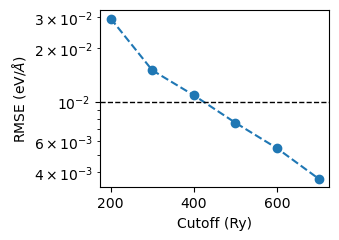

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

rmse = [np.sqrt(np.power(f - forces[-1], 2).mean()) for f in forces]
ax.semilogy(cutoffs[:-1], rmse[:-1], '--o')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [1e-2]*2, 'k--', lw=1)

ax.set_xlabel('Cutoff (Ry)')
ax.set_ylabel('RMSE (eV/$\\AA$)')
fig.tight_layout()
fig.savefig('figures/cutoff-convergence-forces.png', dpi=320)

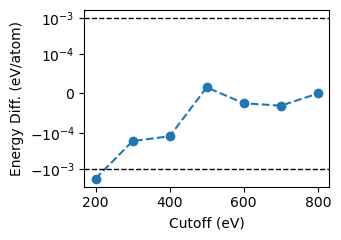

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(cutoffs, np.subtract(energy, energy[-1]) / len(atoms), '--o')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [1e-3]*2, 'k--', lw=1)
ax.plot(ax.get_xlim(), [-1e-3]*2, 'k--', lw=1)

ax.set_yscale('symlog', linthresh=1e-4)

ax.set_xlabel('Cutoff (eV)')
ax.set_ylabel('Energy Diff. (eV/atom)')
fig.tight_layout()
fig.savefig('figures/cutoff-convergence-energy.png', dpi=320)

It seems like a cutoff of 500 is sufficient to get forces within 10 meV/Ang and energies within 1 meV/atom

In [12]:
buffers = np.arange(2., 5.1, 1.)
calc.set(cutoff=chosen_cutoff * units.Ry)

In [13]:
forces = []
energy = []
for buffer in tqdm(buffers):
    my_energy, my_forces = _run_cp2k(atoms, chosen_cutoff, buffer)
        
    forces.append(my_forces)
    energy.append(my_energy)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [11:47<00:00, 176.83s/it]


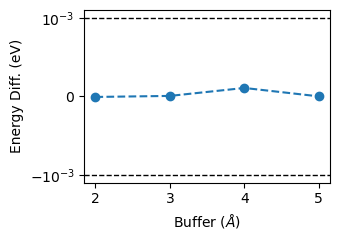

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(buffers[:len(energy)], np.subtract(energy, energy[-1]) / len(atoms), '--o')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [1e-3]*2, 'k--', lw=1)
ax.plot(ax.get_xlim(), [-1e-3]*2, 'k--', lw=1)

ax.set_yscale('symlog', linthresh=1e-3)

ax.set_xlabel('Buffer ($\\AA$)')
ax.set_ylabel('Energy Diff. (eV)')
fig.tight_layout()
fig.savefig('figures/buffer-convergence-energy.png', dpi=320)

A buffer of 5 is where things stop mattering

Results collected over runs with different molecules

Cutoffs (eV)

| MolID | Charge | BLYP/DZVP | B3LYP/DZVP |
|-------|--------|--|------------|
| 0 | 1 | ?  | ? |
| 0 | 0 | 400 | 400 |
| 0 | -1 | 300 | 300 |
| 1 | 1 | 600 | 500 | 
| 1 | 0 | 500  | 400  |
| 1 | -1 | 300 | 300 |
| *Maximum* |  | 600 | 500 |

Buffer Size, Angstrom

| MolID | Charge | BLYP/DZVP | B3LYP/DZVP |
|-------|--------|-----------|------------|
| 0 | 1 | ? | ? |
| 0 | 0 | 2 | 2 |
| 0 | -1 | 3 | 3 |
| 1 | 1 | 2 | 2
| 1 | 0 | 2 | 2 |
| 1 | -1 | 3 | 2 |
| *Maximum* | | 3 | 3 |

? - Outlier. E.g., there was never consistent forces in the range tested